# Late EDA 

In [1]:
import pandas as pd
import re
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial import distance_matrix

In [2]:
PATH_DATA = '../data/'

## Data Import

In [3]:
df_dlg = pd.read_csv(PATH_DATA+'friends_all_dialogue_semi_cln.csv')

## Creating Label

Take care of places

In [4]:
place_dlg_cnt = df_dlg.scenes_places.value_counts()
place_dlg_cnt[place_dlg_cnt>200].sort_values(ascending=False).index.tolist()
place_dict = {'[central perk]': 1,
 "[monica and rachel's]":2,
 "[monica and chandler's]":2,
 "[chandler and joey's]":3,
 "[joey and rachel's]":3,
 '[monica]':2,
 "[monica and rachel's apartment]":2,
 "[monica and chandler's apartment]":2,
 "[ross's apartment]":4,
 "[monica's apartment]":2,
 "[joey's apartment]":3,
 '[unknown]':0,
 '[the hallway]':5,
 "[monica and rachel's erm]":2,
 '[a restaurant]':6,
 "[joey and rachel's apartment]":3,
 "[chandler and joey's apartment]":3,
 "[rachel's office]":7,
 '[the hospital]':8,
 '[chandler]':3,
 "[phoebe's apartment]":9,
 "[chandler's office]":10,
 "[ross and rachel's]":4,
 '[a street]':0,
 "[at chandler and joey's]":3,
 '[central perk]]':1,
 '[the delivery room]':8,
 "[at monica and rachel's]":2,
 "[monica's bedroom]":2,
 "[monica and phoebe's]":2,
 "[ross and rachel's apartment]":4,
 "[monica and chandler's bedroom]":2,
 "[rachel's room]":2,
 '[the beach house]':0,
 '[outside central perk]':0,
 '[silvercup studios]':11,
 '[the park]':0,
 "[chandler and joey's erm]":3,
 "[phoebe and rachel's]":9,
 '[barbados]':0,
 "[carol and susan's]":0,
 '[mr]':0,
 '[the theatre]':0,
 '[the semi private labor room]':8,
 "[rachel's bedroom]":2,
 "[i'm surprised that rachel and ross didn't say they weren't either here]]":0,
 "[chandler and monica's]":2,
 "[bloomingdale's]":7,
 "[chandler and monica's apartment]":2,
 '[the hallway between the apartments]':5,
 '[the rest stop]':6,
 '[the restaurant]':6,
 "[monica and chandler's apartment]]":2,
 '[the anniversary party]':0,
 "[phoebe's cab]":0,
 '[monica and chandlers apartment]':2,
 "[monica and rachel's balcony]":2,
 '[later on in the hallway between the apartments]':5,
 '[the roof]':0,
 '[the waiting room]':0,
 '[continued from earlier]':0,
 '[dr]':0,
 '[the airport]':0,
 "[chandler and monica's apartment]]":2,
 '[the moondance diner]':6,
             
 '[the charity event]':0,
 "[joey and janine's]":3,
 "[chandler and eddie's apartment]":3,
 "[rachel's old room]":2,
 '[restaurant]':6,
 "[ross' apartment]":4,
 "[monica's restaurant kitchen]":12,
 '[the reception hall]':0,
 '[the porsche]':0,
 "[joanna's office]":7,
 "[monica and chandler's new apartment]":2,
 '[the movie set]':11,
 "[joey's apartment]]":3,
 "[chandler's apartment]":3,
 '[central park]':1,
 '[the bar]':0,
 "[rachel and joey's apartment]]":3,
 "[chandler and monica's]]":2,
 "[rachel and monica's]":2,
 '[the street in front of central perk]':0,
 '[the recovery room]':8}

In [5]:
df_dlg['label_place'] = df_dlg.scenes_places.apply(lambda x : place_dict[x] if x in list(place_dict.keys()) 
                                                   else 0)
df_dlg['label_place'].value_counts()

2     18980
0     18883
1     10512
3      6812
4      1704
6       991
5       867
8       862
7       673
9       505
10      328
11      278
12       95
Name: label_place, dtype: int64

In [6]:
# place_dlg_cnt = df_dlg[df_dlg.label_place == -1].scenes_places.value_counts()
# place_dlg_cnt[place_dlg_cnt>50].sort_values(ascending=False).index.tolist()

In [7]:
# char_dlg_cnt = df_dlg.character.value_counts()
# char_dlg_cnt[char_dlg_cnt>100].index.tolist()
char = ['rachel', 'ross', 'monica', 'chandler', 'joey', 'phoebe']
char_id = [1,2,3,4,5,6]
char2id = dict(zip(char+['other'],char_id+[0]))

In [8]:
df_dlg['label_str'] = df_dlg.character.apply(lambda x : x if x in char else 'other')
df_dlg['label'] = df_dlg.label_str.apply(lambda x : char2id[x])

In [9]:
df_dlg.head(10)

,eps,dialogue_ids,scenes_places,character,dialogue,dialogue2,dialogue3,label_place,label_str,label
0,0101,0,[central perk],monica,there's nothing to tell! he's just some guy ...,there's nothing to tell! he's just some guy ...,there's nothing to tell he's just some guy i w...,1,monica,3
1,0101,1,[central perk],joey,"c'mon, you're going out with the guy! there'...","c'mon, you're going out with the guy! there'...",c'mon you're going out with the guy there's go...,1,joey,5
2,0101,2,[central perk],chandler,"all right joey, be nice. so does he have a...","all right joey, be nice. so does he have a...",all right joey be nice so does he have a hump ...,1,chandler,4
3,0101,3,[central perk],phoebe,"wait, does he eat chalk? (they all stare, be...","wait, does he eat chalk?",wait does he eat chalk,1,phoebe,6
4,0101,4,[central perk],phoebe,"just, 'cause, i don't want her to go through...","just, 'cause, i don't want her to go through...",just because i don't want her to go through wh...,1,phoebe,6
5,0101,5,[central perk],monica,"okay, everybody relax. this is not even a da...","okay, everybody relax. this is not even a da...",okay everybody relax this is not even a date i...,1,monica,3
6,0101,6,[central perk],chandler,sounds like a date to me. [time lapse],sounds like a date to me.,sounds like a date to me,1,chandler,4
7,0101,7,[central perk],chandler,"alright, so i'm back in high school, i'm sta...","alright, so i'm back in high school, i'm sta...",alright so i'm back in high school i'm standin...,1,chandler,4
8,0101,8,[central perk],all,"oh, yeah. had that dream.","oh, yeah. had that dream.",oh yeah had that dream,1,other,0
9,0101,9,[central perk],chandler,"then i look down, and i realize there's a ph...","then i look down, and i realize there's a ph...",then i look down and i realize there's a phone...,1,chandler,4


In [10]:
dlg_cnt = df_dlg.label_str.value_counts()
dlg_cnt

other       10797
rachel       9248
ross         9055
monica       8383
chandler     8355
joey         8176
phoebe       7476
Name: label_str, dtype: int64

In [11]:
# df_dlg[(df_dlg.dialogue3.isnull())]

In [12]:
df_dlg['season']= df_dlg['eps'].apply(lambda x : x[:2])
df_dlg.season.unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10'],
      dtype=object)

In [13]:
# df_dlg = df_dlg[~(df_dlg.dialogue3.isnull())]
df_dlg['is_null'] = df_dlg.dialogue3.isnull()

## Null data

In [14]:
df_dlg.groupby('label_str').is_null.mean()

label_str
chandler    0.000359
joey        0.001101
monica      0.004056
other       0.004909
phoebe      0.000669
rachel      0.000973
ross        0.000552
Name: is_null, dtype: float64

In [15]:
df_dlg[df_dlg.is_null==1]

,eps,dialogue_ids,scenes_places,character,dialogue,dialogue2,dialogue3,label_place,label_str,label,season,is_null
1673,0107,156,[rachel has gone off on her own to look for th...,paolo,(something italian),,NaN,0,other,0,01,True
1682,0107,165,[monica and rachel's],paolo,(something in italian),,NaN,2,other,0,01,True
1695,0107,178,[monica and rachel's],paolo,"(something in italian, he is apparently attr...",,NaN,2,other,0,01,True
1704,0107,187,[monica and rachel's],paolo,(something romantic in italian about rachel ...,,NaN,2,other,0,01,True
4181,0117,247,[central perk],phoebe,(as ursula),,NaN,1,phoebe,6,01,True
...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0917,58,[rachel's room],rachel,(threatening joey with a scrunchy),,NaN,2,rachel,1,09,True
54524,0919,93,[phoebe in front of restaurant again]],phoebe,"(with a fancy dress, still playing and singing)",,NaN,0,phoebe,6,09,True
54749,0920,51,[central perk],monica,(fingering her elbow),,NaN,1,monica,3,09,True
56103,0923-0924,528,[the hotel game room],mike,(doing monica and mumbling),,NaN,0,other,0,09,True


## Sentence Length

In [16]:
# df_dlg.dialogue4 = df_dlg.dialogue4.fillna('')
# df_dlg.dialogue4 = df_dlg.dialogue4.str.strip()
# df_dlg['len_dialogue4'] = df_dlg.dialogue4.str.split().apply(lambda x : len(x))

df_dlg.dialogue3 = df_dlg.dialogue3.fillna('')
df_dlg.dialogue3 = df_dlg.dialogue3.str.strip()
df_dlg['len_dialogue3'] = df_dlg.dialogue3.str.split().apply(lambda x : len(x))

In [17]:
df_dlg[df_dlg['len_dialogue3']==1].sample(10)

,eps,dialogue_ids,scenes_places,character,dialogue,dialogue2,dialogue3,label_place,label_str,label,season,is_null,len_dialogue3
27708,0514,162,[monica and rachel's],phoebe,eh?,eh?,eh,2,phoebe,6,05,False,1
36982,0624,492,[central perk],joey,yeah.,yeah.,yeah,1,joey,5,06,False,1
10660,0220,133,[central perk],ross,huh?,huh?,huh,1,ross,2,02,False,1
49846,0901,203,[rachel's room],rachel,surprised?,surprised?,surprised,2,rachel,1,09,False,1
30748,0601,194,[phoebe's cab],joey,yes.,yes.,yes,0,joey,5,06,False,1
4103,0117,169,[monica and rachel's],phoebe,trouble?,trouble?,trouble,2,phoebe,6,01,False,1
35070,0618,211,[joey's apartment],rachel,really?,really?,really,3,rachel,1,06,False,1
57867,1006,222,[ross' office],benjamin,ooor ...,ooor ...,ooor,0,other,0,10,False,1
21433,0413,220,[bloomingdale's],rachel,really?,really?,really,7,rachel,1,04,False,1
24613,0502,37,[monica and rachel's],joey,later! (exits.),later!,later,2,joey,5,05,False,1


In [18]:
df_dlg[df_dlg['len_dialogue3']==1].label_str.value_counts()/dlg_cnt

chandler    0.102334
joey        0.112402
monica      0.110104
other       0.135871
phoebe      0.111557
rachel      0.137651
ross        0.127002
Name: label_str, dtype: float64

In [19]:
df_dlg['len_dialogue3'].describe()

count    61490.000000
mean        10.313498
std         10.707187
min          0.000000
25%          3.000000
50%          7.000000
75%         14.000000
max        239.000000
Name: len_dialogue3, dtype: float64

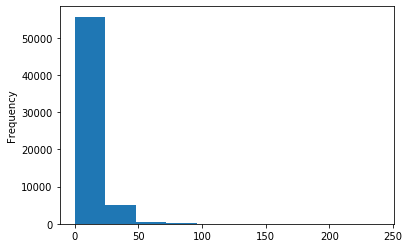

In [20]:
df_dlg['len_dialogue3'].plot(kind = 'hist')

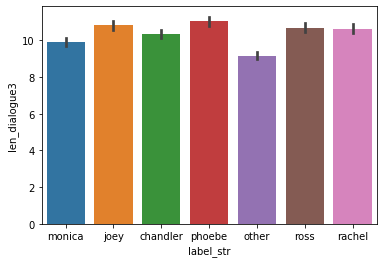

In [21]:
sns.barplot(data = df_dlg[['label_str','len_dialogue3']], x = 'label_str', y = 'len_dialogue3')

In [22]:
# med_len = df_dlg[['season','label_str','len_dialogue3']].groupby(['season','label_str']).median().reset_index()

In [23]:
# plt.figure(figsize = (10,10))
# sns.lineplot(data = med_len, x = 'season', y = 'len_dialogue3', hue = 'label_str')

## Word Cloud

In [24]:
# def filt_word1(sent, wordlist):
#     use = True
#     if len(sent.split(' '))>7:
#         for w in wordlist:
#             if w in sent:
#                 use = False
#                 break
#     return use

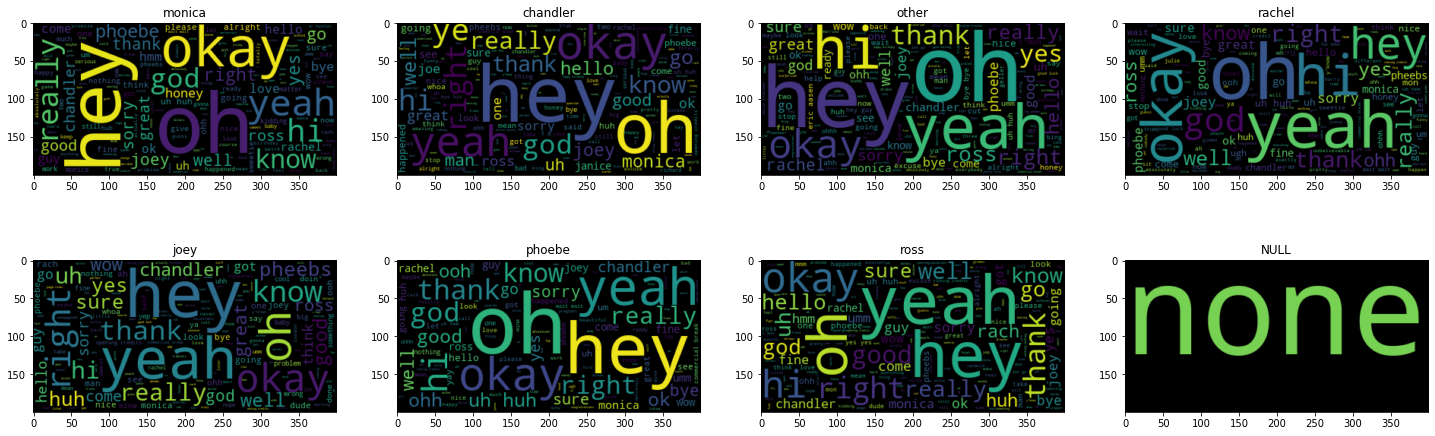

In [25]:
## World Cloud
fig, axes = plt.subplots(nrows=2, ncols=4, figsize = (25,8))

rr = 0
cc = 0
df_dlg0 = df_dlg[df_dlg['season'].isin(['01', '02', '03', '04', '05', '06', '07', '08'])]
for i in df_dlg.label_str.unique():
    text1 = ' '.join(df_dlg0[(df_dlg0.label_str==i) & (df_dlg0.len_dialogue3<5)].dialogue3.tolist())
    wordcloud1 = WordCloud().generate(text1)
    axes[rr,cc].set_title(i)
    axes[rr,cc].imshow(wordcloud1, interpolation='bilinear')
    
    rr += 1
    
    if rr>=2:
        rr = 0
        cc += 1

wordcloud1 = WordCloud().generate('none only, none')
axes[1,3].set_title('NULL')
axes[1,3].imshow(wordcloud1, interpolation='bilinear')

In [26]:
en_stops = stopwords.words('english')

In [27]:
# ## top 20
# df_dlg0 = df_dlg[df_dlg['season'].isin(['01', '02', '03', '04', '05', '06', '07', '08'])]
# all_tp = []
# for i in df_dlg.label_str.unique():
#     text1 = ' '.join(df_dlg0[(df_dlg0.label_str==i) & (df_dlg0.len_dialogue3<5)].dialogue3.tolist())
#     text1_ls = pd.Series(text1.split(' '))
#     text1_ls2 = text1_ls.value_counts()
#     tp = list(text1_ls2[:40].keys())    
#     all_tp += tp
    
# all_tp = pd.Series(all_tp)
# all_tp_cnt = all_tp.value_counts()

# stop2 = all_tp_cnt[all_tp_cnt>=4].keys().tolist()
# print(set(stop2)-set(en_stops))

In [28]:
# further_stopwords = ['got', 'one', 'hey', 'yeah', 'come', "i'm", 'see', "can't", 'look', 'oh', 'go', 'well', 'okay', 'mean', "y'know", 'right',
#                      'want', 'uh', 'know', 'think', 'like', "that's", 'good', 'get', 'gonna', 'really'] + ['guy']

further_stopwords = ['yeah','okay','hey','hi','oh','really','yes','hello','thanks','sure','ok','huh','wow',
                     'bye','thank','know','right','sorry','good','well'] 

def lose_stop(sentence):
    word_list = sentence.split(' ')
    new_sen = []
    if len(word_list)< 5:
        for w in word_list:
            if w not in further_stopwords:
                new_sen.append(w)
    else:
        new_sen = word_list
    
    return ' '.join(new_sen)

/Users/alamhanz/anaconda/envs/p37/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


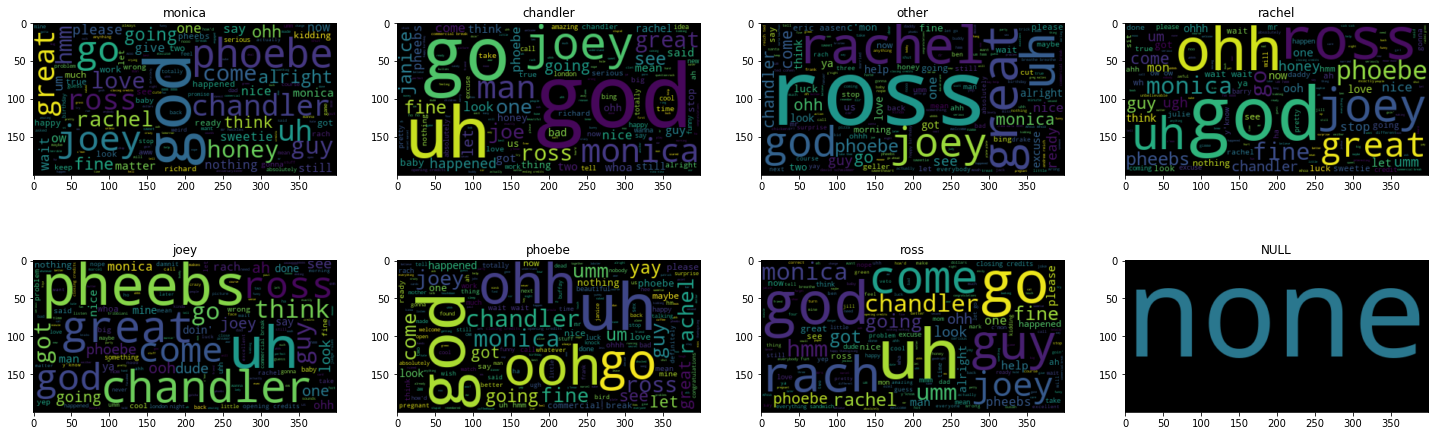

In [29]:
## World Cloud (more than 7) --> filter
fig, axes = plt.subplots(nrows=2, ncols=4, figsize = (25,8))

rr = 0
cc = 0
df_dlg0 = df_dlg[df_dlg['season'].isin(['01', '02', '03', '04', '05', '06', '07', '08'])]

df_dlg0['dialogue5'] = df_dlg0.dialogue3.apply(lambda x : lose_stop(x))


for i in df_dlg.label_str.unique():
    text1 = ' '.join(df_dlg0[(df_dlg0.label_str==i) & (df_dlg0.len_dialogue3<5)].dialogue5.tolist())
    wordcloud1 = WordCloud().generate(text1)
    axes[rr,cc].set_title(i)
    axes[rr,cc].imshow(wordcloud1, interpolation='bilinear')
    
    rr += 1
    
    if rr>=2:
        rr = 0
        cc += 1

wordcloud1 = WordCloud().generate('none only, none')
axes[1,3].set_title('NULL')
axes[1,3].imshow(wordcloud1, interpolation='bilinear')

In [30]:
## dialogue5
df_dlg['dialogue5'] = df_dlg.dialogue3.apply(lambda x : lose_stop(x))
df_dlg.dialogue5 = df_dlg.dialogue5.fillna('')
df_dlg.dialogue5 = df_dlg.dialogue5.str.strip()
df_dlg['len_dialogue5'] = df_dlg.dialogue5.str.split().apply(lambda x : len(x))
df_dlg['is_null2'] = df_dlg['len_dialogue5']==0

In [31]:
XX=df_dlg['len_dialogue5']
XX.describe()

count    61490.000000
mean        10.142885
std         10.844733
min          0.000000
25%          3.000000
50%          7.000000
75%         14.000000
max        239.000000
Name: len_dialogue5, dtype: float64

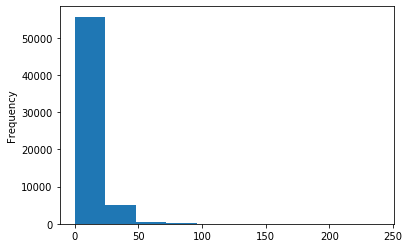

In [32]:
XX.plot(kind='hist')

In [33]:
np.percentile(XX,99)

50.0

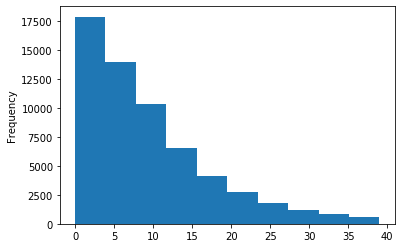

In [34]:
XX[XX<40].plot(kind='hist')

In [35]:
df_dlg2 = df_dlg[['eps','dialogue_ids','scenes_places','label_place','label_str','label','season','dialogue','dialogue5','len_dialogue5','is_null2']]

In [36]:
df_dlg2.groupby('label_str').is_null2.mean()

label_str
chandler    0.066068
joey        0.073019
monica      0.063700
other       0.080300
phoebe      0.080391
rachel      0.089317
ross        0.078851
Name: is_null2, dtype: float64

In [37]:
# df_dlg2 = df_dlg2[(df_dlg2['len_dialogue5']>0)&(df_dlg2['len_dialogue5']<50)][['dialogue5','label','eps','season','label_place']]
# df_dlg2.columns = ['text','label','episode','season','places']
# df_dlg2['ids'] = [i for i in range(len(df_dlg2))]

In [38]:
df_dlg2.head()

,eps,dialogue_ids,scenes_places,label_place,label_str,label,season,dialogue,dialogue5,len_dialogue5,is_null2
0,0101,0,[central perk],1,monica,3,01,there's nothing to tell! he's just some guy ...,there's nothing to tell he's just some guy i w...,11,False
1,0101,1,[central perk],1,joey,5,01,"c'mon, you're going out with the guy! there'...",c'mon you're going out with the guy there's go...,14,False
2,0101,2,[central perk],1,chandler,4,01,"all right joey, be nice. so does he have a...",all right joey be nice so does he have a hump ...,16,False
3,0101,3,[central perk],1,phoebe,6,01,"wait, does he eat chalk? (they all stare, be...",wait does he eat chalk,5,False
4,0101,4,[central perk],1,phoebe,6,01,"just, 'cause, i don't want her to go through...",just because i don't want her to go through wh...,16,False


In [39]:
df_dlg2.shape

(61490, 11)

In [40]:
# df_dlg2[df_dlg2.is_null2==1]

In [41]:
df_dlg2['ids'] = [i for i in range(len(df_dlg2))]

/Users/alamhanz/anaconda/envs/p37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Spliting

In [42]:
df_dlg2_seen=df_dlg2[df_dlg2['season'].isin(['01', '02', '03', '04', '05', '06', '07', '08'])]
train_ids = df_dlg2_seen.sample(int(len(df_dlg2_seen)*0.75),random_state = 167).ids.tolist()
df_dlg2_seen['is_train'] = df_dlg2_seen.ids.isin(train_ids)
df_dlg2_unseen=df_dlg2[df_dlg2['season'].isin(['09', '10'])]

/Users/alamhanz/anaconda/envs/p37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
len(train_ids)

37232

In [44]:
df_dlg2_seen['is_train'].mean()

0.7499949640432689

In [45]:
df_dlg2_seen.head(10)

,eps,dialogue_ids,scenes_places,label_place,label_str,label,season,dialogue,dialogue5,len_dialogue5,is_null2,ids,is_train
0,0101,0,[central perk],1,monica,3,01,there's nothing to tell! he's just some guy ...,there's nothing to tell he's just some guy i w...,11,False,0,True
1,0101,1,[central perk],1,joey,5,01,"c'mon, you're going out with the guy! there'...",c'mon you're going out with the guy there's go...,14,False,1,False
2,0101,2,[central perk],1,chandler,4,01,"all right joey, be nice. so does he have a...",all right joey be nice so does he have a hump ...,16,False,2,True
3,0101,3,[central perk],1,phoebe,6,01,"wait, does he eat chalk? (they all stare, be...",wait does he eat chalk,5,False,3,False
4,0101,4,[central perk],1,phoebe,6,01,"just, 'cause, i don't want her to go through...",just because i don't want her to go through wh...,16,False,4,True
5,0101,5,[central perk],1,monica,3,01,"okay, everybody relax. this is not even a da...",okay everybody relax this is not even a date i...,21,False,5,True
6,0101,6,[central perk],1,chandler,4,01,sounds like a date to me. [time lapse],sounds like a date to me,6,False,6,True
7,0101,7,[central perk],1,chandler,4,01,"alright, so i'm back in high school, i'm sta...",alright so i'm back in high school i'm standin...,22,False,7,True
8,0101,8,[central perk],1,other,0,01,"oh, yeah. had that dream.",oh yeah had that dream,5,False,8,True
9,0101,9,[central perk],1,chandler,4,01,"then i look down, and i realize there's a ph...",then i look down and i realize there's a phone...,11,False,9,False


In [46]:
df_dlg2_unseen.head()

,eps,dialogue_ids,scenes_places,label_place,label_str,label,season,dialogue,dialogue5,len_dialogue5,is_null2,ids
49643,0901,0,[rachel's room],2,rachel,1,09,joey. (he turns to face rachel on one knee w...,joey,1,False,49643
49644,0901,1,[rachel's room],2,rachel,1,09,(seeing the ring) oh my god. (pause) okay. (...,my god,2,False,49644
49645,0901,2,[rachel's room],2,rachel,1,09,so uh...i guess we should...make it official...,so uh i guess we should make it official huh,10,False,49645
49646,0901,3,[rachel's room],2,joey,5,09,uh... look rach...(ross enters.) hey ross is...,uh look rach hey ross is here hey look it's my...,16,False,49646
49647,0901,4,[rachel's room],2,ross,2,09,hey joey. (to rachel) hey you.,joey you,2,False,49647


## Second Dataset

In [47]:
df_dlg2_seen2 = df_dlg2_seen.copy()
df_dlg2_seen2.rename(columns = {'dialogue5':'text2'},inplace = True)
df_dlg2_seen2['text1'] = df_dlg2_seen2.groupby(['eps'])['text2'].shift(1)
df_dlg2_seen2['label_prev'] = df_dlg2_seen2.groupby(['eps'])['label'].shift(1)
df_dlg2_seen2['label_str_prev'] = df_dlg2_seen2.groupby(['eps'])['label_str'].shift(1)
df_dlg2_seen2['is_null2_prev'] = df_dlg2_seen2.groupby(['eps'])['is_null2'].shift(1)

df_dlg2_seen2 = df_dlg2_seen2[df_dlg2_seen2['label']!=df_dlg2_seen2['label_prev']] 
df_dlg2_seen2

,eps,dialogue_ids,scenes_places,label_place,label_str,label,season,dialogue,text2,len_dialogue5,is_null2,ids,is_train,text1,label_prev,label_str_prev,is_null2_prev
0,0101,0,[central perk],1,monica,3,01,there's nothing to tell! he's just some guy ...,there's nothing to tell he's just some guy i w...,11,False,0,True,NaN,NaN,NaN,NaN
1,0101,1,[central perk],1,joey,5,01,"c'mon, you're going out with the guy! there'...",c'mon you're going out with the guy there's go...,14,False,1,False,there's nothing to tell he's just some guy i w...,3.0,monica,False
2,0101,2,[central perk],1,chandler,4,01,"all right joey, be nice. so does he have a...",all right joey be nice so does he have a hump ...,16,False,2,True,c'mon you're going out with the guy there's go...,5.0,joey,False
3,0101,3,[central perk],1,phoebe,6,01,"wait, does he eat chalk? (they all stare, be...",wait does he eat chalk,5,False,3,False,all right joey be nice so does he have a hump ...,4.0,chandler,False
5,0101,5,[central perk],1,monica,3,01,"okay, everybody relax. this is not even a da...",okay everybody relax this is not even a date i...,21,False,5,True,just because i don't want her to go through wh...,6.0,phoebe,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49637,0823,524,[the delivery room],8,joey,5,08,sure.,,0,True,49637,True,oh hon can you grab me my other box of tissues...,1.0,rachel,False
49638,0823,525,[the delivery room],8,rachel,1,08,okay. (he moves ross's coat to get the tissu...,,0,True,49638,True,,5.0,joey,True
49639,0823,526,[the delivery room],8,joey,5,08,my god.,my god,2,False,49639,False,,1.0,rachel,True
49640,0823,527,[the delivery room],8,rachel,1,08,joey. (he turns to face rachel on one knee w...,joey,1,False,49640,False,my god,5.0,joey,False


In [48]:
df_dlg2_seen2['label'].value_counts()

0    7549
1    7464
2    7143
3    6708
4    6620
5    6442
6    5876
Name: label, dtype: int64

In [49]:
df_dlg2_unseen2 = df_dlg2_unseen.copy()
df_dlg2_unseen2.rename(columns = {'dialogue5':'text2'},inplace = True)
df_dlg2_unseen2['text1'] = df_dlg2_unseen2.groupby(['eps'])['text2'].shift(1)
df_dlg2_unseen2['label_prev'] = df_dlg2_unseen2.groupby(['eps'])['label'].shift(1)
df_dlg2_unseen2['label_str_prev'] = df_dlg2_unseen2.groupby(['eps'])['label_str'].shift(1)
df_dlg2_unseen2['is_null2_prev'] = df_dlg2_unseen2.groupby(['eps'])['is_null2'].shift(1)

df_dlg2_unseen2 = df_dlg2_unseen2[df_dlg2_unseen2['label']!=df_dlg2_unseen2['label_prev']] 
df_dlg2_unseen2

,eps,dialogue_ids,scenes_places,label_place,label_str,label,season,dialogue,text2,len_dialogue5,is_null2,ids,text1,label_prev,label_str_prev,is_null2_prev
49643,0901,0,[rachel's room],2,rachel,1,09,joey. (he turns to face rachel on one knee w...,joey,1,False,49643,NaN,NaN,NaN,NaN
49646,0901,3,[rachel's room],2,joey,5,09,uh... look rach...(ross enters.) hey ross is...,uh look rach hey ross is here hey look it's my...,16,False,49646,so uh i guess we should make it official huh,1.0,rachel,False
49647,0901,4,[rachel's room],2,ross,2,09,hey joey. (to rachel) hey you.,joey you,2,False,49647,uh look rach hey ross is here hey look it's my...,5.0,joey,False
49648,0901,5,[rachel's room],2,rachel,1,09,hey you.,you,1,False,49648,joey you,2.0,ross,False
49649,0901,6,[rachel's room],2,joey,5,09,hey and look he brought flowers. thanks ross...,hey and look he brought flowers thanks ross bu...,16,False,49649,you,1.0,rachel,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61485,1017-1018,580,[monica and chandler's apartment],2,chandler,4,10,"oh, it's gonna be okay. (chandler hugs her. m...",oh it's gonna be okay,5,False,61485,this is harder than i thought it would be,3.0,monica,False
61486,1017-1018,581,[monica and chandler's apartment],2,rachel,1,10,(crying) do you guys have to go to the new ho...,do you guys have to go to the new house right ...,18,False,61486,oh it's gonna be okay,4.0,chandler,False
61487,1017-1018,582,[monica and chandler's apartment],2,monica,3,10,we got some time.,we got some time,4,False,61487,do you guys have to go to the new house right ...,1.0,rachel,False
61488,1017-1018,583,[monica and chandler's apartment],2,rachel,1,10,"okay, should we get some coffee?",okay should we get some coffee,6,False,61488,we got some time,3.0,monica,False


## Saving

In [50]:
len(df_dlg2_seen),len(df_dlg2_unseen),len(df_dlg2_seen2),len(df_dlg2_unseen2)

(49643, 11847, 47802, 11301)

In [51]:
df_dlg2_seen = df_dlg2_seen[df_dlg2_seen.is_null2 == 0]
df_dlg2_unseen = df_dlg2_unseen[df_dlg2_unseen.is_null2 == 0]

df_dlg2_seen2 = df_dlg2_seen2[(df_dlg2_seen2.is_null2 == 0)&(df_dlg2_seen2.is_null2_prev == 0)]
df_dlg2_unseen2 = df_dlg2_unseen2[(df_dlg2_unseen2.is_null2 == 0)&(df_dlg2_unseen2.is_null2_prev == 0)]

In [52]:
len(df_dlg2_seen),len(df_dlg2_unseen),len(df_dlg2_seen2),len(df_dlg2_unseen2)

(45764, 11035, 40867, 9832)

In [53]:
df_dlg2_seen.to_csv('../data/friends_seen_season_1.csv',index=False)
df_dlg2_unseen.to_csv('../data/friends_unseen_season_1.csv',index=False)

df_dlg2_seen2.to_csv('../data/friends_seen_season2_2.csv',index=False)
df_dlg2_unseen2.to_csv('../data/friends_unseen_season2_2.csv',index=False)

## LDA Analysis

In [55]:
# df_dlg2_seen

In [56]:
# corpus = df_dlg2_seen['dialogue5'].tolist()
# vectorizer = TfidfVectorizer(min_df = 0.1, max_features = 100)
# vectorizer.fit(corpus)

In [57]:
# df1 = df_dlg2_seen[df_dlg2_seen.label_str == 'monica'].sample(5)
# V_M = vectorizer.transform(df1['dialogue5']).toarray()

# df0 = df_dlg2_seen[df_dlg2_seen.label_str == 'joey'].sample(5)
# V_J = vectorizer.transform(df0['dialogue5']).toarray()

In [58]:
# distance_matrix(V_M, V_J)

In [59]:
# distance_matrix([V_M[3]],[V_J[2]])

In [60]:
# df1['dialogue5'].iloc[3]

In [61]:
# df0['dialogue5'].iloc[2]

## Who Talk Places

In [62]:
WTP = df_dlg2_seen.groupby(['label_place','label_str']).size().unstack()
WTP2 = (WTP.transpose() / WTP.sum(axis = 1)).fillna(0).transpose()

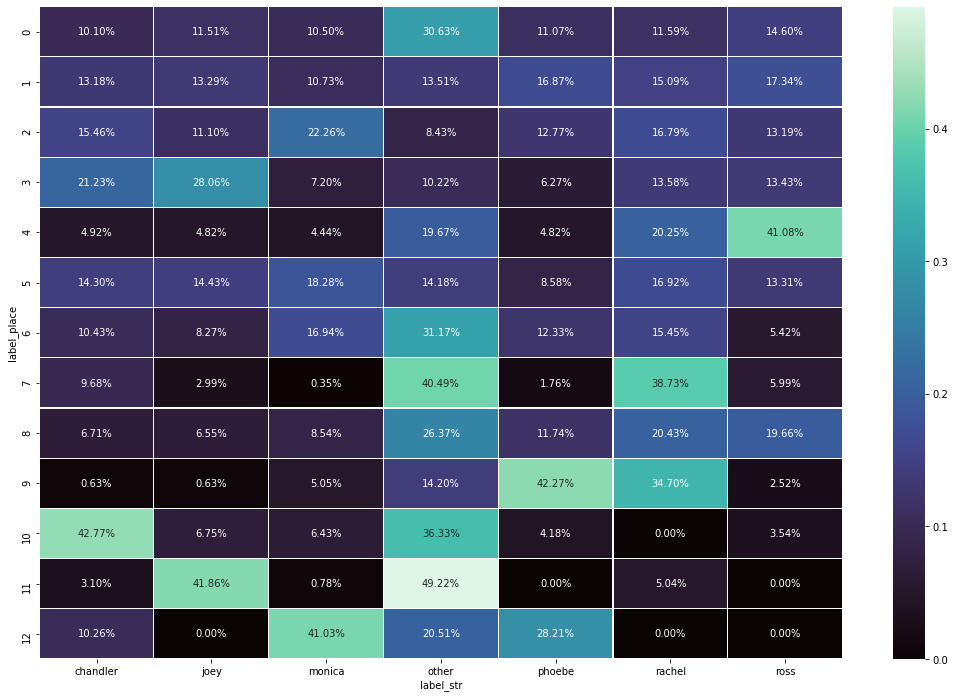

In [63]:
plt.figure(figsize=(18, 12))
sns.heatmap(WTP2, annot=True, fmt=".2%", linewidths=.2, cmap="mako")

## Who talk Who

In [64]:
df_dlg2_seen2.head()

,eps,dialogue_ids,scenes_places,label_place,label_str,label,season,dialogue,text2,len_dialogue5,is_null2,ids,is_train,text1,label_prev,label_str_prev,is_null2_prev
1,0101,1,[central perk],1,joey,5,01,"c'mon, you're going out with the guy! there'...",c'mon you're going out with the guy there's go...,14,False,1,False,there's nothing to tell he's just some guy i w...,3.0,monica,False
2,0101,2,[central perk],1,chandler,4,01,"all right joey, be nice. so does he have a...",all right joey be nice so does he have a hump ...,16,False,2,True,c'mon you're going out with the guy there's go...,5.0,joey,False
3,0101,3,[central perk],1,phoebe,6,01,"wait, does he eat chalk? (they all stare, be...",wait does he eat chalk,5,False,3,False,all right joey be nice so does he have a hump ...,4.0,chandler,False
5,0101,5,[central perk],1,monica,3,01,"okay, everybody relax. this is not even a da...",okay everybody relax this is not even a date i...,21,False,5,True,just because i don't want her to go through wh...,6.0,phoebe,False
6,0101,6,[central perk],1,chandler,4,01,sounds like a date to me. [time lapse],sounds like a date to me,6,False,6,True,okay everybody relax this is not even a date i...,3.0,monica,False


In [65]:
def rearrange(x):
    if type(x) == str:
        x0 = x.split('_')
        x0.sort()
        return '_'.join(x0)
    else:
        return None

In [66]:
df_dlg2_seen2['connect'] = (df_dlg2_seen2['label_str_prev']+"_"+df_dlg2_seen2['label_str']).apply(rearrange)

/Users/alamhanz/anaconda/envs/p37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [67]:
WTW = df_dlg2_seen2.groupby(['connect','season']).size().unstack()
WTW2 = (WTW / WTW.sum(axis = 0)).fillna(0)
# WTW2

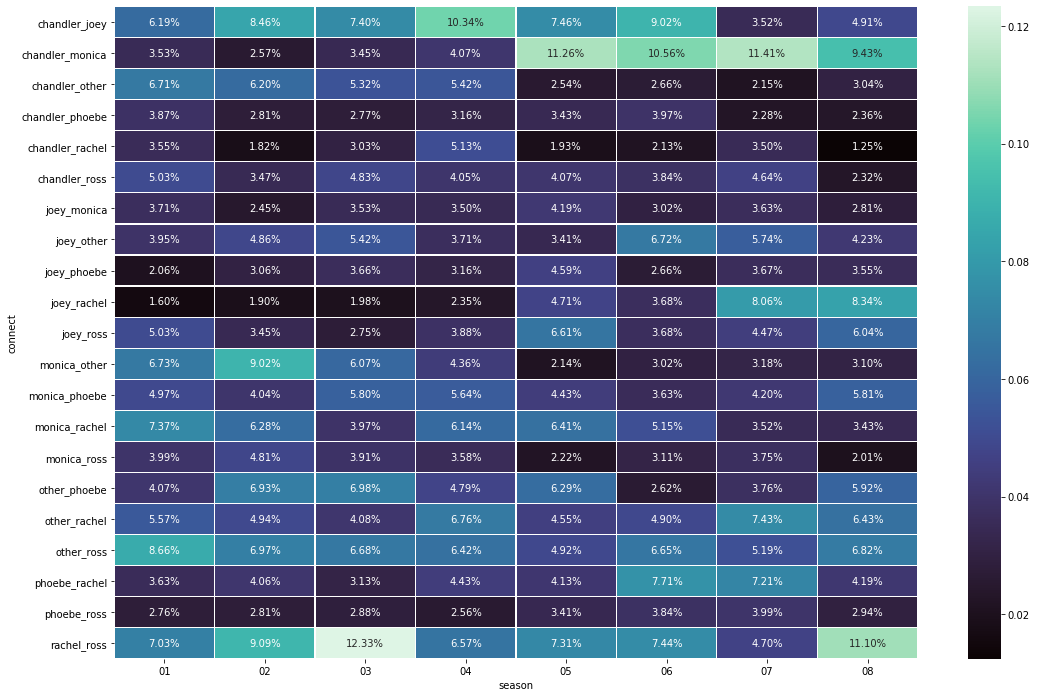

In [68]:
plt.figure(figsize=(18, 12))
sns.heatmap(WTW2, annot=True, fmt=".2%", linewidths=.2, cmap="mako")

In [69]:
WTO = df_dlg2_seen2[df_dlg2_seen2.label_prev == 0].groupby(['label_str','season']).size().unstack()
WTO2 = (WTO / WTO.sum(axis = 0)).fillna(0)

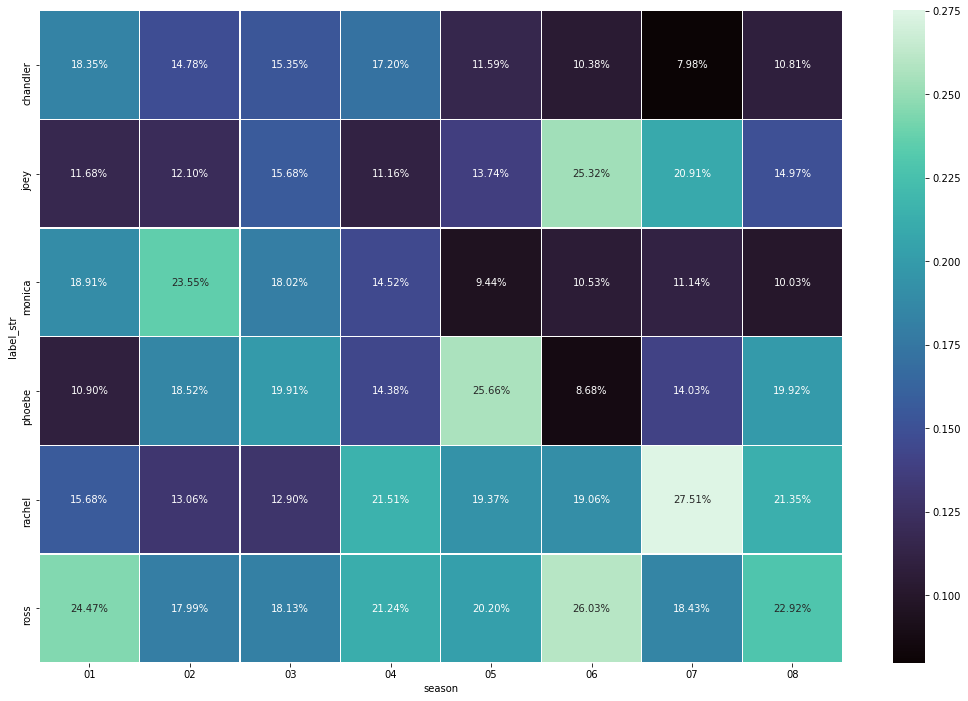

In [70]:
plt.figure(figsize=(18, 12))
sns.heatmap(WTO2, annot=True, fmt=".2%", linewidths=.2, cmap="mako")

In [1]:
char = ['rachel', 'ross', 'monica', 'chandler', 'joey', 'phoebe']
char_id = [0,1,2,3,4,5]

dict(zip(char_id,char))

{0: 'rachel', 1: 'ross', 2: 'monica', 3: 'chandler', 4: 'joey', 5: 'phoebe'}